In [1]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

##### For Preprocessing #####
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

##### For Building the Model #####
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline

##### For Validation of the Model #####
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

# I. Preparing data

## Load data

In [2]:
# Load the data
df = pd.read_csv("data/twitchdata.csv") # ORIGINAL DATA, NO PROCESSING
df.drop(['Channel'], axis = 1, inplace = True) # Remove non quantifiable features
df.drop(['Language'], axis = 1, inplace = True) # Remove non quantifiable features

print("Size of the data:", df.shape)
df.head()

Size of the data: (1000, 9)


,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature
0,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False
1,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False
2,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True
3,3970318140,517740,300575,7714,3944850,703986,106546942,True,False
4,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False


## Find NaN or missing values

In [3]:
df.isna().sum().sum() # Sum up NA values

0

## Convert quantifiable column values

In [4]:
# Convert columns with True/False to 1/0
df["Partnered"] = df["Partnered"].astype(int)
df["Mature"] = df["Mature"].astype(int)

df.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature
0,6196161750,215250,222720,27716,3246298,1734810,93036735,1,0
1,6091677300,211845,310998,25610,5310163,1370184,89705964,1,0
2,5644590915,515280,387315,10976,1767635,1023779,102611607,1,1
3,3970318140,517740,300575,7714,3944850,703986,106546942,1,0
4,3671000070,123660,285644,29602,8938903,2068424,78998587,1,0


## Visualize data
### Look for outliers in original data via Boxplots

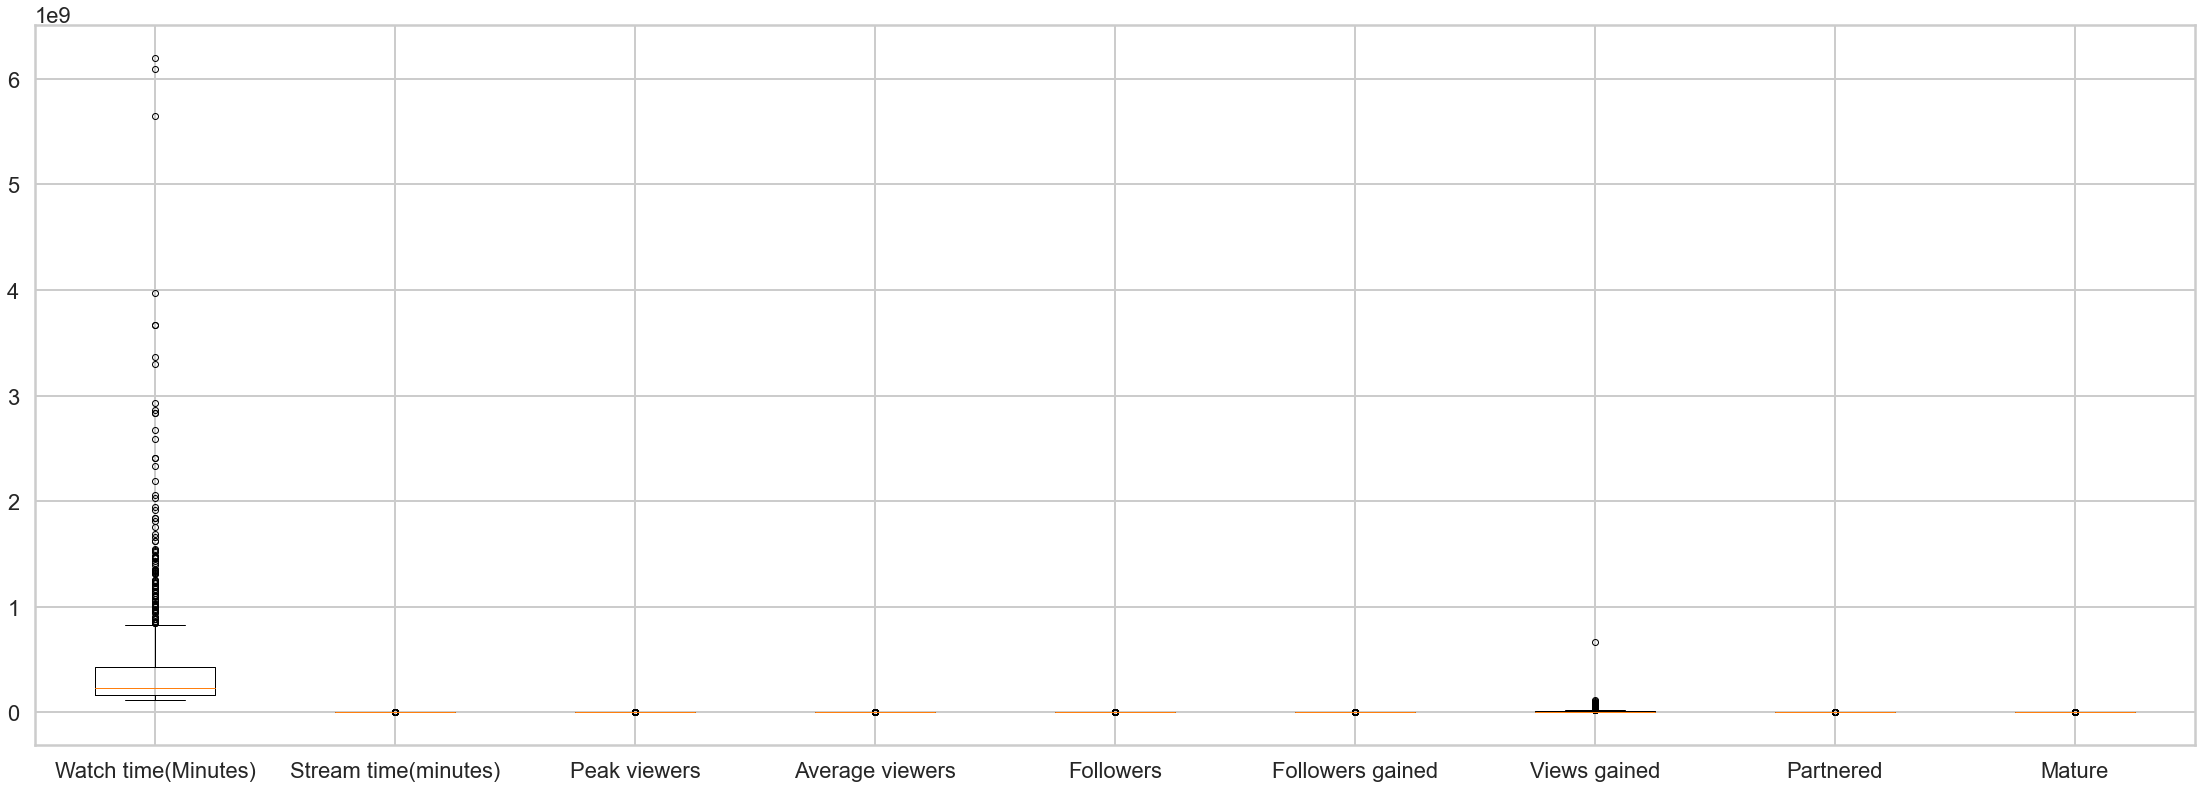

In [5]:
# Displays data of a dataframe in boxplots
def display_boxplot(data):
  data_values = []
  for col in df.columns:
    data_values.append(data[col])

  fig = plt.figure(figsize =(30, 10))
  
  # Creating axes instance
  ax = fig.add_axes([0, 0, 1, 1])
  
  # Creating plot
  bp = ax.boxplot(data_values, labels=data.columns)
  
  # show plot
  plt.show()


display_boxplot(df)

## Minimize outliers in original data (but only in features with initially numerical values)

In [6]:
# Returns upper and lower limit in a data column
def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + (1.5 * IQR)
    lower_limit = Q1 - (1.5 * IQR)
    
    return upper_limit, lower_limit


upper, lower = outliers(df, "Watch time(Minutes)")
print("Upper whisker: ", upper)
print("Lower Whisker: ", lower)

Upper whisker:  839564953.125
Lower Whisker:  -242635141.875


In [7]:
numerical_columns = ['Watch time(Minutes)', 'Stream time(minutes)', 'Peak viewers', 'Average viewers', 'Followers', 'Followers gained', 'Views gained']

df_no_outliers = df # Copy original data

# Remove or minimize outliers
for col in numerical_columns:
  upper, lower = outliers(df_no_outliers, col) # Get upper and lower limit of column's values
  print(upper, lower)
  df_no_outliers = df_no_outliers[(df_no_outliers[col] > lower) & (df_no_outliers[col] < upper)] # 

839564953.125 -242635141.875
243127.5 -30052.5
59394.375 -21916.625
6584.75 -1719.25
929807.5 -310912.5
332065.25 -144306.75
14978220.25 -3491073.75


### Updated original data with minimal outliers

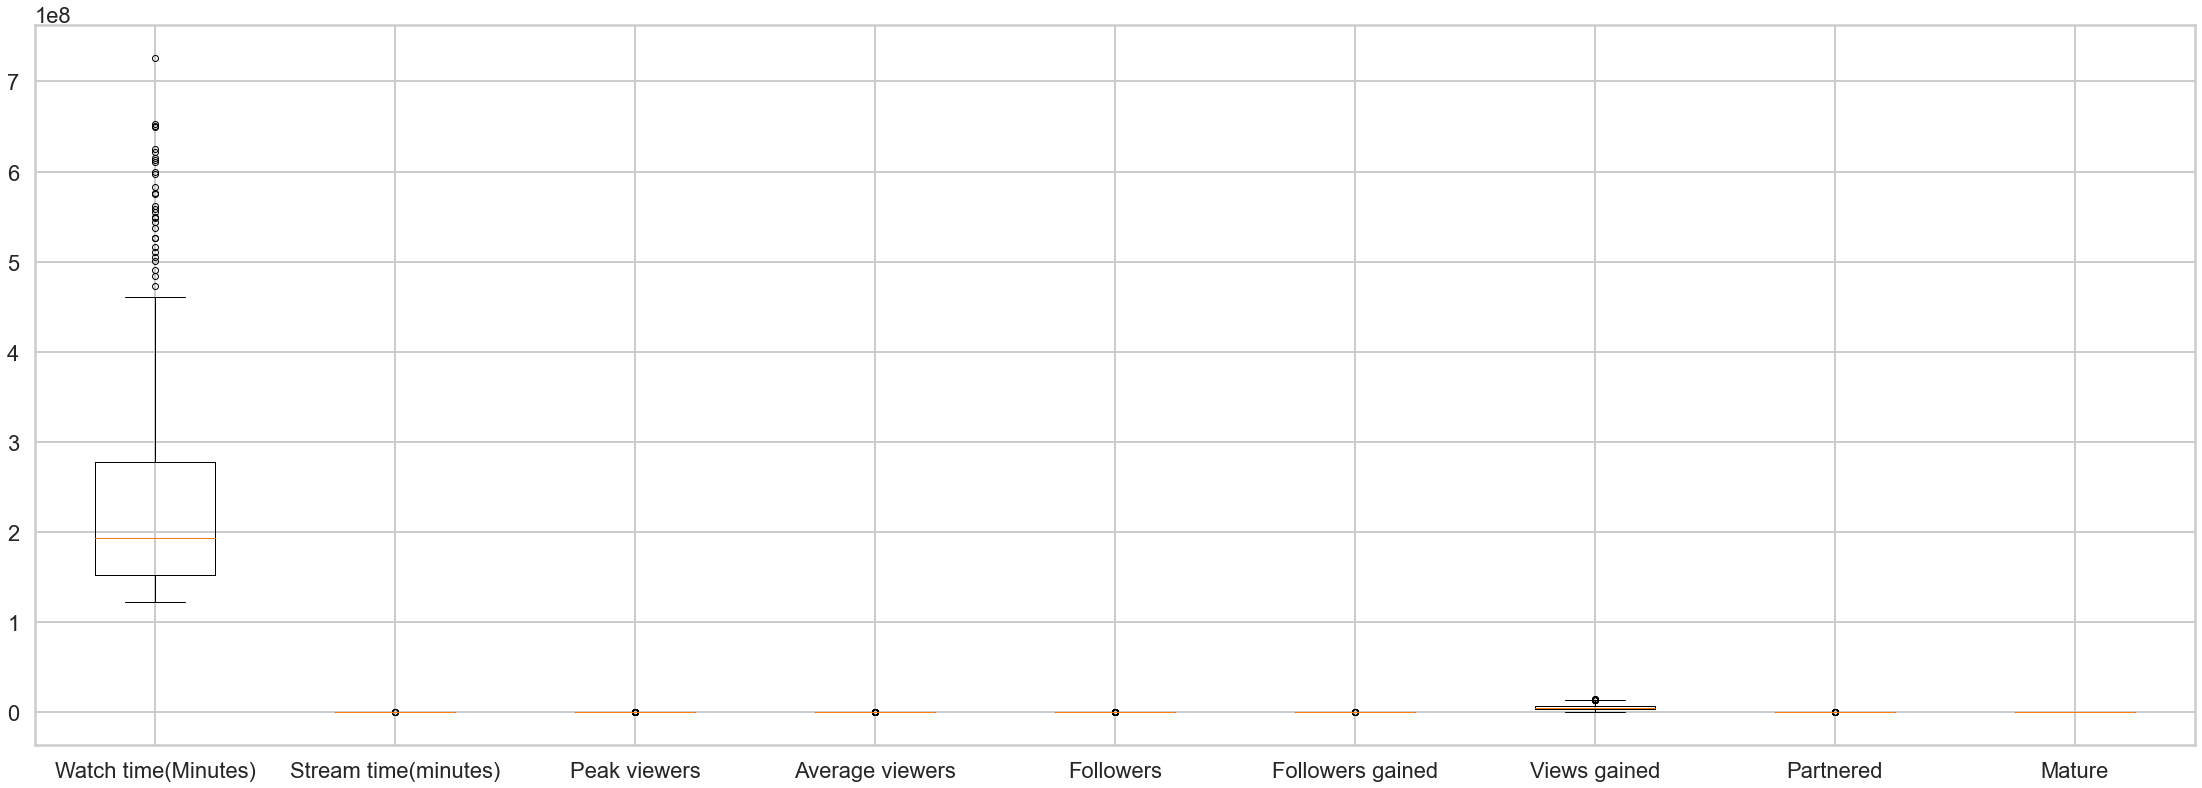

In [8]:
display_boxplot(df_no_outliers)

In [9]:
print("Updated data size: ", df_no_outliers.shape)
df_no_outliers.head()

Updated data size:  (613, 9)


,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature
122,726000045,145755,13080,4922,346566,37883,12800182,1,0
136,653181210,187530,33646,3270,817365,29415,13757678,1,0
138,650910525,162690,24101,3894,571183,115692,8579344,1,1
140,649761570,145050,14480,4420,423002,249048,14109245,1,1
146,625142130,115650,13945,5216,331632,77979,13181386,1,0



## Standardize data

In [10]:
numerical_columns = ['Watch time(Minutes)', 'Stream time(minutes)', 'Peak viewers', 'Average viewers', 'Followers', 'Followers gained', 'Views gained']

twitch_data = df_no_outliers  # copy data with no outliers to twitch_data

# Standardize values in numerical columns
for col in numerical_columns:
    col_mean = twitch_data[col].mean()
    col_std = twitch_data[col].std()

    twitch_data[col] = (twitch_data[col] - col_mean)/col_std

print("twitch_data size: ", twitch_data.shape)
twitch_data.head()

twitch_data size:  (613, 9)


,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature
122,4.436954,0.779229,-0.156030,2.248601,0.292531,-0.748607,2.319729,1,0
136,3.784368,1.768083,1.801552,0.880306,2.750159,-0.854707,2.632937,1,0
138,3.764019,1.180097,0.893008,1.397144,1.465059,0.226307,0.939045,1,1
140,3.753722,0.762541,-0.022771,1.832812,0.691536,1.897201,2.747938,1,1
146,3.533089,0.066615,-0.073695,2.492111,0.214574,-0.246221,2.444425,1,0


## Divide predictors (x) and label (y) data

In [11]:
x = twitch_data.drop("Average viewers", axis = 1)
y = twitch_data["Average viewers"]

In [12]:
x.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Followers,Followers gained,Views gained,Partnered,Mature
122,4.436954,0.779229,-0.156030,0.292531,-0.748607,2.319729,1,0
136,3.784368,1.768083,1.801552,2.750159,-0.854707,2.632937,1,0
138,3.764019,1.180097,0.893008,1.465059,0.226307,0.939045,1,1
140,3.753722,0.762541,-0.022771,0.691536,1.897201,2.747938,1,1
146,3.533089,0.066615,-0.073695,0.214574,-0.246221,2.444425,1,0


In [13]:
y.head()

122    2.248601
136    0.880306
138    1.397144
140    1.832812
146    2.492111
Name: Average viewers, dtype: float64

## Divide training and test datasets

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) # Training=0.75, Test=0.25

print("x_train size:", x_train.shape)
print("y_train size:", y_train.shape)
print("\nx_test size:", x_test.shape)
print("y_test size:", y_test.shape)

x_train size: (459, 8)
y_train size: (459,)

x_test size: (154, 8)
y_test size: (154,)


In [15]:
x_train.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Followers,Followers gained,Views gained,Partnered,Mature
442,0.283108,0.530329,-0.644998,0.564332,1.518808,2.283732,1,0
601,-0.277294,0.217518,-0.790822,-0.747395,-0.429742,-0.300786,1,0
329,0.978568,-0.300876,0.834659,-0.254642,0.169047,-0.425024,1,1
874,-0.807360,-1.975359,2.890568,-0.091785,2.013525,0.088155,1,0
370,0.684944,-1.363583,3.787309,-0.220549,-0.323478,2.521799,1,0


# II. Building the models

In [16]:
# Linear regression function
# Returns predicted values, model coefficients, regression score
def linear_regression(Xtrain, Ytrain, Xtest):
    
    model = LinearRegression()  
    
    model.fit(Xtrain, Ytrain) # Fit model with sklearn

    Ypred = model.predict(Xtest) # Predict with x_test data
    
    # Get model coefficients
    coefficients = {} 
    for i in range(len(model.coef_)):
        coefficients[Xtrain.columns[i]] = model.coef_[i]
        
    print("Intercept: ", model.intercept_)
    
    return Ypred, coefficients, model.score(Xtest, y_test)

# Returns evaluations scores
# Prints scatter plot of actual and predicted values
def evaluate_model(Ypred, Ytest):
    f, ax = plt.subplots(figsize=(10, 7))
   
    # Fit linear regression via least squares with numpy.polyfit
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    m, b = np.polyfit(Ypred, Ytest, deg=1) # slope, intercept

    plt.scatter(Ypred, Ytest, color='black')
  
    xseq = np.linspace(0, 10, num=100)   # Sequence of 100 numbers from 0 to 100 
    ax.plot(Ypred, (m * Ypred) + b, color="red"); # Regression line

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs Predicted")

    
    return {"R2": r2_score(Ypred, Ytest) * 100, "MAE": mean_absolute_error(Ypred, Ytest), 
            "MSE": mean_squared_error(Ypred, Ytest), "RMSE": np.sqrt(mean_squared_error(Ypred, Ytest))}


### Dataframe for evaluation results

In [17]:
eval_results = pd.DataFrame(columns=["Predictor/s", "R2", "MAE", "MSE", "RMSE", "Regression Score", "Cross-Val Mean"])
eval_results

,Predictor/s,R2,MAE,MSE,RMSE,Regression Score,Cross-Val Mean


## Setup 1 - Model with all features

Intercept:  0.29330150816426054


C:\Users\User\AppData\Local\Temp\ipykernel_17252\2453350127.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results = eval_results.append(setup_1_eval, ignore_index=True)


,Predictor/s,R2,MAE,MSE,RMSE,Regression Score,Cross-Val Mean
0,All,80.503011,0.287223,0.162777,0.403456,0.827471,70.89072


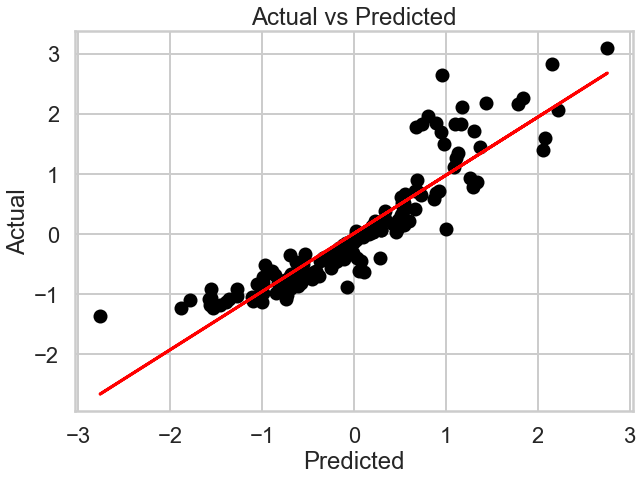

In [18]:
# Predict
setup_1_pred, coef_1, regr_score_1 = linear_regression(x_train, y_train, x_test)

# Evaluation
setup_1_eval = evaluate_model(setup_1_pred, y_test)

# Cross Validation
cv_score = cross_val_score(LinearRegression(), x[x_train.columns], y, cv=10)

# Compile evaluation results
setup_1_eval.update({"Predictor/s": "All", "Cross-Val Mean": cv_score.mean() * 100, "Regression Score": regr_score_1})

eval_results = eval_results.append(setup_1_eval, ignore_index=True)
eval_results

In [19]:
pd.DataFrame(coef_1, index=["Coef"])

,Watch time(Minutes),Stream time(minutes),Peak viewers,Followers,Followers gained,Views gained,Partnered,Mature
Coef,0.726076,-0.680808,0.05976,0.021213,0.018277,0.006903,-0.312851,0.047701


## Setup 2 - Model with selected features (Followers and Stream time)

In [20]:
x_train_selected = x_train[['Followers', 'Stream time(minutes)']]
x_train_selected.head()

,Followers,Stream time(minutes)
442,0.564332,0.530329
601,-0.747395,0.217518
329,-0.254642,-0.300876
874,-0.091785,-1.975359
370,-0.220549,-1.363583


In [21]:
x_test_selected = x_test[['Followers', 'Stream time(minutes)']]
x_test_selected.head()

,Followers,Stream time(minutes)
709,-0.699130,-0.545160
350,0.329704,-0.748612
388,-0.117864,-0.136836
736,0.113554,1.402367
996,-0.403593,0.950725


Intercept:  -0.01419497672320232


C:\Users\User\AppData\Local\Temp\ipykernel_17252\3674765435.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results = eval_results.append(setup_2_eval, ignore_index=True)


,Predictor/s,R2,MAE,MSE,RMSE,Regression Score,Cross-Val Mean
0,All,80.503011,0.287223,0.162777,0.403456,0.827471,70.89072
1,"Followers, Stream time(minutes)",-71.367993,0.602017,0.58566,0.765284,0.379254,-6.129891


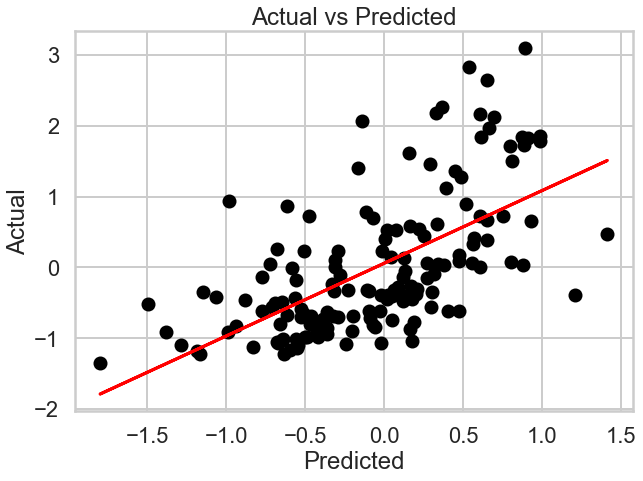

In [22]:
# Predict
setup_2_pred, coef_2, regr_score_2 = linear_regression(x_train_selected, y_train, x_test_selected)

# Evaluation
setup_2_eval = evaluate_model(setup_2_pred, y_test)

# Cross Validation
cv_score = cross_val_score(LinearRegression(), x[x_train_selected.columns], y, cv=10)

# Compile evaluation results
setup_2_eval.update({"Predictor/s": ", ".join(x_train_selected.columns), "Cross-Val Mean": cv_score.mean() * 100, "Regression Score": regr_score_2})

eval_results = eval_results.append(setup_2_eval, ignore_index=True)
eval_results

In [23]:
pd.DataFrame(coef_2, index=["Coef"])

,Followers,Stream time(minutes)
Coef,0.292029,-0.491101


## Setup 3 - Feature Selection with Pearson Correlation

### Pearson Correlation

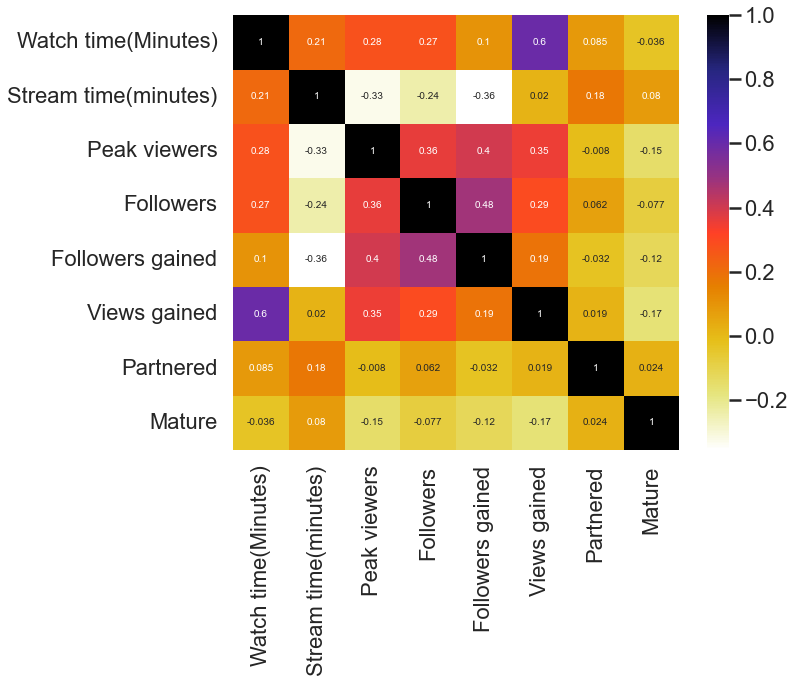

In [24]:
cor = x_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
plt.show() 

# NOTE: If the value is near to 1, the two features are correlated and we can drop any one of them (https://www.naukri.com/learning/articles/feature-selection-techniques-python-code/)

#### Finding correlated features

In [25]:
# Selects highly correlated features
def correlation(data, threshold):
    col_corr = set()  
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]                  
                col_corr.add(colname)

    return col_corr 

### Different correlation thresholds (0.3, 0.4, 0.5)

In [26]:
# Using different correlation thresholds
corr_features_1 = correlation(x_train, 0.3)
print(corr_features_1)

corr_features_2 = correlation(x_train, 0.4) 
print(corr_features_2)

corr_features_3 = correlation(x_train, 0.5) 
print(corr_features_3)

{'Views gained', 'Peak viewers', 'Followers gained', 'Followers'}
{'Views gained', 'Followers gained'}
{'Views gained'}


## Setup 3.1: Selected features with threshold=0.3 (weak correlations)

In [27]:
x_train_selected_1 = x_train.drop(corr_features_1, axis=1)
x_test_selected_1 = x_test.drop(corr_features_1, axis=1)

x_train_selected_1.head()

,Watch time(Minutes),Stream time(minutes),Partnered,Mature
442,0.283108,0.530329,1,0
601,-0.277294,0.217518,1,0
329,0.978568,-0.300876,1,1
874,-0.807360,-1.975359,1,0
370,0.684944,-1.363583,1,0


Intercept:  0.2603301825528816


C:\Users\User\AppData\Local\Temp\ipykernel_17252\1561624480.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results = eval_results.append(setup_3_1_eval, ignore_index=True)


,Predictor/s,R2,MAE,MSE,RMSE,Regression Score,Cross-Val Mean
0,All,80.503011,0.287223,0.162777,0.403456,0.827471,70.89072
1,"Followers, Stream time(minutes)",-71.367993,0.602017,0.58566,0.765284,0.379254,-6.129891
2,"Watch time(Minutes), Stream time(minutes), Par...",80.575612,0.297512,0.162575,0.403206,0.827686,70.514282


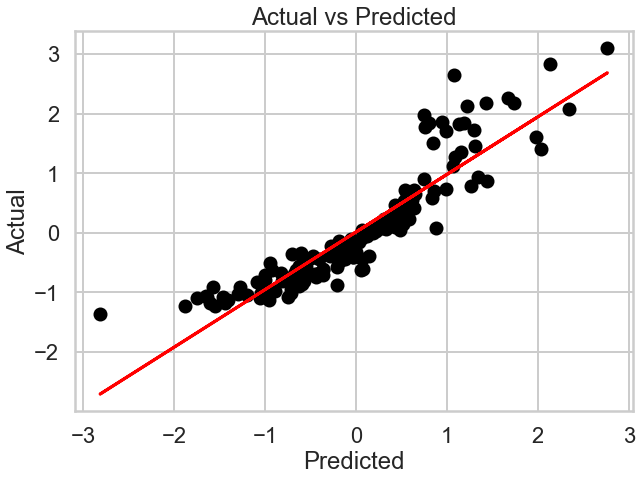

In [28]:
# Predict
setup_3_1_pred, coef_3_1, regr_score_3_1 = linear_regression(x_train_selected_1, y_train, x_test_selected_1)

# Evaluation
setup_3_1_eval = evaluate_model(setup_3_1_pred, y_test)

# Cross Validation
cv_score = cross_val_score(LinearRegression(), x[x_train_selected_1.columns], y, cv=10)

# Compile evaluation results
setup_3_1_eval.update({"Predictor/s": ", ".join(x_train_selected_1.columns), "Cross-Val Mean": cv_score.mean() * 100, "Regression Score": regr_score_3_1})

eval_results = eval_results.append(setup_3_1_eval, ignore_index=True)
eval_results

In [29]:
pd.DataFrame(coef_3_1, index=["Coef"])

,Watch time(Minutes),Stream time(minutes),Partnered,Mature
Coef,0.762565,-0.720557,-0.273532,0.025943


## Setup 3.2: Selected features with threshold=0.4

In [30]:
x_train_selected_2 = x_train.drop(corr_features_2, axis=1)
x_test_selected_2 = x_test.drop(corr_features_2,axis=1)

x_train_selected_2.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Followers,Partnered,Mature
442,0.283108,0.530329,-0.644998,0.564332,1,0
601,-0.277294,0.217518,-0.790822,-0.747395,1,0
329,0.978568,-0.300876,0.834659,-0.254642,1,1
874,-0.807360,-1.975359,2.890568,-0.091785,1,0
370,0.684944,-1.363583,3.787309,-0.220549,1,0


Intercept:  0.29777710951312125


C:\Users\User\AppData\Local\Temp\ipykernel_17252\3087918405.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results = eval_results.append(setup_3_2_eval, ignore_index=True)


,Predictor/s,R2,MAE,MSE,RMSE,Regression Score,Cross-Val Mean
0,All,80.503011,0.287223,0.162777,0.403456,0.827471,70.89072
1,"Followers, Stream time(minutes)",-71.367993,0.602017,0.58566,0.765284,0.379254,-6.129891
2,"Watch time(Minutes), Stream time(minutes), Par...",80.575612,0.297512,0.162575,0.403206,0.827686,70.514282
3,"Watch time(Minutes), Stream time(minutes), Pea...",80.730591,0.285443,0.160915,0.401142,0.829445,71.12983


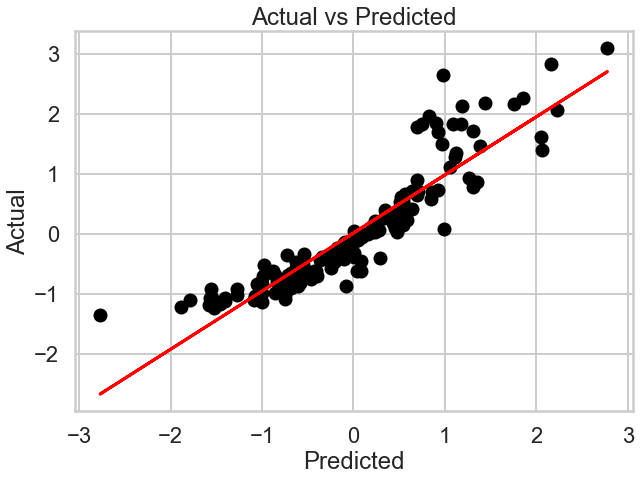

In [31]:
# Predict
setup_3_2_pred, coef_3_2, regr_score_3_2 = linear_regression(x_train_selected_2, y_train, x_test_selected_2)

# Evaluation
setup_3_2_eval = evaluate_model(setup_3_2_pred, y_test)

# Cross Validation
cv_score = cross_val_score(LinearRegression(), x[x_train_selected_2.columns], y, cv=10)

# Compile evaluation results
setup_3_2_eval.update({"Predictor/s": ", ".join(x_train_selected_2.columns), "Cross-Val Mean": cv_score.mean() * 100, "Regression Score": regr_score_3_2})

eval_results = eval_results.append(setup_3_2_eval, ignore_index=True)
eval_results

In [32]:
pd.DataFrame(coef_3_2, index=["Coef"])

,Watch time(Minutes),Stream time(minutes),Peak viewers,Followers,Partnered,Mature
Coef,0.72955,-0.684541,0.064437,0.028368,-0.316929,0.043872


## Setup 3.3 Selected features with threshold=0.5

In [33]:
x_train_selected_3 = x_train.drop(corr_features_3, axis=1)
x_test_selected_3 = x_test.drop(corr_features_3, axis=1)

x_train_selected_3.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Followers,Followers gained,Partnered,Mature
442,0.283108,0.530329,-0.644998,0.564332,1.518808,1,0
601,-0.277294,0.217518,-0.790822,-0.747395,-0.429742,1,0
329,0.978568,-0.300876,0.834659,-0.254642,0.169047,1,1
874,-0.807360,-1.975359,2.890568,-0.091785,2.013525,1,0
370,0.684944,-1.363583,3.787309,-0.220549,-0.323478,1,0


Intercept:  0.2950977639852698


C:\Users\User\AppData\Local\Temp\ipykernel_17252\2576597541.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results = eval_results.append(setup_3_3_eval, ignore_index=True)


,Predictor/s,R2,MAE,MSE,RMSE,Regression Score,Cross-Val Mean
0,All,80.503011,0.287223,0.162777,0.403456,0.827471,70.89072
1,"Followers, Stream time(minutes)",-71.367993,0.602017,0.58566,0.765284,0.379254,-6.129891
2,"Watch time(Minutes), Stream time(minutes), Par...",80.575612,0.297512,0.162575,0.403206,0.827686,70.514282
3,"Watch time(Minutes), Stream time(minutes), Pea...",80.730591,0.285443,0.160915,0.401142,0.829445,71.12983
4,"Watch time(Minutes), Stream time(minutes), Pea...",80.509738,0.287418,0.1629,0.403609,0.82734,71.051783


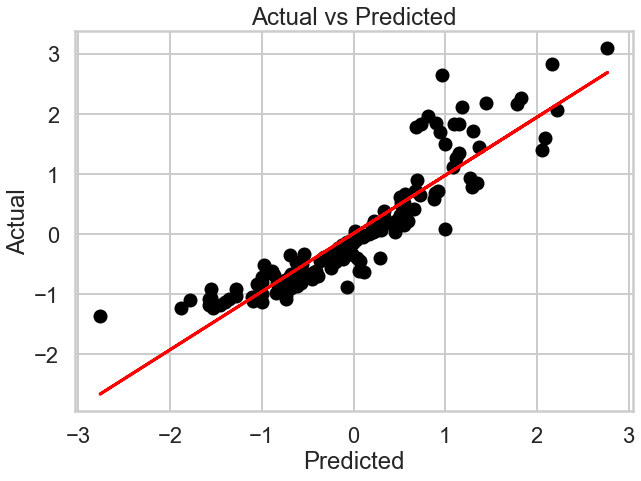

In [34]:
# Predict
setup_3_3_pred, coef_3_3, regr_score_3_3 = linear_regression(x_train_selected_3, y_train, x_test_selected_3)

# Evaluation
setup_3_3_eval = evaluate_model(setup_3_3_pred, y_test)

# Cross Validation
cv_score = cross_val_score(LinearRegression(), x[x_train_selected_3.columns], y, cv=10)

# Compile evaluation results
setup_3_3_eval.update({"Predictor/s": ", ".join(x_train_selected_3.columns), "Cross-Val Mean": cv_score.mean() * 100, "Regression Score": regr_score_3_3})

eval_results = eval_results.append(setup_3_3_eval, ignore_index=True)
eval_results

In [35]:
pd.DataFrame(coef_3_3, index=["Coef"])

,Watch time(Minutes),Stream time(minutes),Peak viewers,Followers,Followers gained,Partnered,Mature
Coef,0.72971,-0.680838,0.060772,0.021738,0.018391,-0.314334,0.045911


## Evaluation Summary

In [36]:
eval_results.set_index("Predictor/s", inplace = True)
eval_results.head()

,R2,MAE,MSE,RMSE,Regression Score,Cross-Val Mean
Predictor/s,,,,,,
All,80.503011,0.287223,0.162777,0.403456,0.827471,70.89072
"Followers, Stream time(minutes)",-71.367993,0.602017,0.58566,0.765284,0.379254,-6.129891
"Watch time(Minutes), Stream time(minutes), Partnered, Mature",80.575612,0.297512,0.162575,0.403206,0.827686,70.514282
"Watch time(Minutes), Stream time(minutes), Peak viewers, Followers, Partnered, Mature",80.730591,0.285443,0.160915,0.401142,0.829445,71.12983
"Watch time(Minutes), Stream time(minutes), Peak viewers, Followers, Followers gained, Partnered, Mature",80.509738,0.287418,0.1629,0.403609,0.82734,71.051783
